In [1]:
import json 
import pandas as pd 
import numpy as np 
import time 
from datetime import timezone 
import os 
import ccxt 
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader 
import torch 
import torch.nn as nn 
import torch.nn.functional as F 
from transformers import * 
import os 
import time
import datetime 
import matplotlib.pyplot as plt
from tqdm import tqdm 
from sklearn.model_selection import train_test_split 
import seaborn as sns 

with open("BTC_USDT-4h-14.json") as f: 
    d = json.load(f)
    
chart_df = pd.DataFrame(d) 
chart_df = chart_df.rename(columns={0:"timestamp", 1:"open", 2:"high", 3:"low", 4:"close", 5:"volume"}) 

def process(df): 
    binance = ccxt.binance()  
    dates = df["timestamp"].values 
    timestamp = [] 
    for i in range(len(dates)): 
        date_string = binance.iso8601(int(dates[i])) 
        date_string = date_string[:10] + " " + date_string[11:-5] 
        timestamp.append(date_string) 
    df["datetime"] = timestamp 
    df = df.drop(columns={"timestamp"}) 
    return df 

chart_df = process(chart_df) 

hours, days, months, years = [], [], [], [] 
for dt in tqdm(chart_df["datetime"]):  
    dtobj = pd.to_datetime(dt) 
    hour = dtobj.hour 
    day = dtobj.day 
    month = dtobj.month 
    year = dtobj.year 
    hours.append(hour) 
    days.append(day) 
    months.append(month) 
    years.append(year) 

chart_df["hours"] = hours
chart_df["days"] = days 
chart_df["months"] = months 
chart_df["years"] = years 

def feature_engineering(df): 
    windows = [5, 10, 20, 60, 120] 
    for window in windows:
        df[f"open_ma{window}"] = df["open"].rolling(window).mean() 
        df[f"open_ma{window}_ratio"] = (df["open"] - df[f"open_ma{window}"]) / df[f"open_ma{window}"] 

        df[f"high_ma{window}"] = df["high"].rolling(window).mean() 
        df[f"high_ma{window}_ratio"] = (df["high"] - df[f"high_ma{window}"]) / df[f"high_ma{window}"] 

        df[f"low_ma{window}"] = df["low"].rolling(window).mean() 
        df[f"low_ma{window}_ratio"] = (df["low"] - df[f"low_ma{window}"]) / df[f"low_ma{window}"] 

        df[f"close_ma{window}"] = df["close"].rolling(window).mean() 
        df[f"close_ma{window}_ratio"] = (df["close"] - df[f"close_ma{window}"]) / df[f"close_ma{window}"] 

        df[f"volume_ma{window}"] = df["volume"].rolling(window).mean() 
        df[f"volume_ma{window}_ratio"] = (df["volume"] - df[f"volume_ma{window}"]) / df[f"volume_ma{window}"]

    K = 12 # forecasting window 
    returns = [None] 
    close = df["close"].values
    for i in range(1, close.shape[0]): 
        ret = close[i] / close[i-1] 
        returns.append(ret) 
    df["returns"] = returns 
    
    df.drop(columns={"open_ma5", "open_ma10", "open_ma20", "open_ma60", "open_ma120",
                     "high_ma5", "high_ma10", "high_ma20", "high_ma60", "high_ma120",
                     "low_ma5", "low_ma10", "low_ma20", "low_ma60", "low_ma120",
                     "close_ma5", "close_ma10", "close_ma20", "close_ma60", "close_ma120",
                     "volume_ma5", "volume_ma10", "volume_ma20", "volume_ma60", "volume_ma120",
                     "open", "high", "low", "close", "volume", "datetime", "years"}, inplace=True) 
    df.dropna(inplace=True) 
    return df 

chart_df = feature_engineering(chart_df) 

M = 24 # input window 
K = 12 # forecasting window 
disc_cols = ["hours", "days", "months"]
cont_cols = [] 
cols = chart_df.columns 
for col in cols: 
    if col not in disc_cols: 
        cont_cols.append(col) 
        
cont = []
disc = [] 
targets = [] 
future_disc = [] 


for i in range(chart_df.shape[0] - M - K):
    cont.append(chart_df[cont_cols].iloc[i:i+M].values) 
    disc.append(chart_df[disc_cols].iloc[i:i+M].values) 
    targets.append(chart_df["returns"].iloc[i+M:i+M+K].values) 
    future_disc.append(chart_df[disc_cols].iloc[i+M:i+M+K].values)
    
cont = torch.tensor(cont).float() 
disc = torch.tensor(disc).float() 
targets = torch.tensor(targets).float() 
future_disc = torch.tensor(future_disc).float() 

cont = cont.unsqueeze(dim=3) 
print("=" * 100) 
print(cont.shape) 
print("=" * 100) 

train_size = int(cont.shape[0] * 0.8) 
val_size = int(cont.shape[0] * 0.1) 

train_cont = cont[:train_size] 
train_disc = disc[:train_size] 
train_targets = targets[:train_size] 
train_future_disc = future_disc[:train_size] 

val_cont = cont[train_size:train_size+val_size] 
val_disc = disc[train_size:train_size+val_size] 
val_targets = targets[train_size:train_size+val_size] 
val_future_disc = future_disc[train_size:train_size+val_size] 

test_cont = cont[train_size+val_size:] 
test_disc = disc[train_size+val_size:] 
test_targets = targets[train_size+val_size:] 
test_future_disc = future_disc[train_size+val_size:] 

BATCH_SIZE = 128 

class CustomDataset(Dataset): 
    def __init__(self, past_cont, past_disc, target_seq, future_disc): 
        self.past_cont = past_cont 
        self.past_disc = past_disc
        self.target_seq = target_seq 
        self.future_disc = future_disc 
    def __len__(self): 
        return len(self.past_cont) 
    def __getitem__(self, i): 
        return {
            "past_cont": torch.tensor(self.past_cont[i], dtype=torch.float32), 
            "past_disc": torch.tensor(self.past_disc[i], dtype=torch.float32), 
            "target_seq": torch.tensor(self.target_seq[i], dtype=torch.float32), 
            "future_disc": torch.tensor(self.future_disc[i], dtype=torch.float32) 
        } 
    
train_dataset = CustomDataset(train_cont, train_disc, train_targets, train_future_disc)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)

val_dataset = CustomDataset(val_cont, val_disc, val_targets, val_future_disc) 
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle = False) 

test_dataset = CustomDataset(test_cont, test_disc, test_targets, test_future_disc) 
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = False) 


/opt/conda/lib/python3.8/site-packages/transformers/generation_utils.py:24: FutureWarning: Importing `GenerationMixin` from `src/transformers/generation_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import GenerationMixin` instead.
  warnings.warn(
100%|██████████| 12206/12206 [00:00<00:00, 19966.30it/s]
/tmp/ipykernel_2116/2645358702.py:117: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:207.)
  cont = torch.tensor(cont).float()


torch.Size([12051, 24, 26, 1])


In [2]:
def a_norm(Q, K): 
    m = torch.matmul(Q, K.transpose(2,1).float()) 
    m /= torch.sqrt(torch.tensor(Q.shape[-1]).float()) 
    return torch.softmax(m, -1) 

def attention(Q, K, V): 
    a = a_norm(Q, K) # (batch_size, dim_attn, seq_length) 
    return torch.matmul(a, V) # (batch_size, seq_length, seq_length) 

class AttentionBlock(torch.nn.Module): 
    def __init__(self, dim_val, dim_attn): 
        super(AttentionBlock, self).__init__()
        self.value = Value(dim_val, dim_val) 
        self.key = Key(dim_val, dim_attn) 
        self.query = Query(dim_val, dim_attn) 
    
    def forward(self, x, kv = None):
        if kv is None:
            # Attention with x connected to Q,K and V (For encoder)
            return attention(self.query(x), self.key(x), self.value(x))
        # Attention with x as Q, external vector kv as K and V (For decoder)
        return attention(self.query(x), self.key(kv), self.value(kv))
    
class MultiHeadAttentionBlock(torch.nn.Module):
    def __init__(self, dim_val, dim_attn, n_heads):
        super(MultiHeadAttentionBlock, self).__init__()
        self.heads = []
        for i in range(n_heads):
            self.heads.append(AttentionBlock(dim_val, dim_attn))
        
        self.fc = nn.Linear(n_heads * dim_val, dim_val, bias = False)
                      
    def forward(self, x, kv = None):
        a = []
        for h in self.heads:
            a.append(h(x, kv = kv))
            
        a = torch.stack(a, dim = -1) #combine heads
        a = a.flatten(start_dim = 2) #flatten all head outputs
        
        x = self.fc(a)
        return x
    
class Value(torch.nn.Module):
    def __init__(self, dim_input, dim_val):
        super(Value, self).__init__()
        self.fc1 = nn.Linear(dim_input, dim_val, bias = False).cuda()
    
    def forward(self, x):
        return self.fc1(x)

class Key(torch.nn.Module):
    def __init__(self, dim_input, dim_attn):
        super(Key, self).__init__()
        self.fc1 = nn.Linear(dim_input, dim_attn, bias = False).cuda()
    
    def forward(self, x):
        return self.fc1(x)

class Query(torch.nn.Module):
    def __init__(self, dim_input, dim_attn):
        super(Query, self).__init__()
        self.fc1 = nn.Linear(dim_input, dim_attn, bias = False).cuda()
    
    def forward(self, x):
        return self.fc1(x)

def QuantileLoss(net_out, Y, q):
    return (q * F.relu(net_out - Y)) + ((1 - q) * F.relu(Y - net_out))


class GLU(torch.nn.Module):
    def __init__(self, dim_input):
        super(GLU, self).__init__()
        self.fc1 = nn.Linear(dim_input, dim_input)
        self.fc2 = nn.Linear(dim_input, dim_input)
    
    def forward(self, x):
        return torch.sigmoid(self.fc1(x)) * self.fc2(x) 

class GRN(torch.nn.Module): 
    def __init__(self, dim_input, dim_out=None, n_hidden=10, dropout_r=0.1):
        super(GRN, self).__init__() 
        if dim_out != None: 
            self.skip = nn.Linear(dim_input, dim_out) 
        else:
            self.skip = None
            dim_out = dim_input 
        self.fc1 = nn.Linear(dim_input, n_hidden) 
        self.fc2 = nn.Linear(n_hidden, dim_out) 
        self.dropout = nn.Dropout(dropout_r) 
        self.gate = GLU(dim_out) 
        self.norm = nn.LayerNorm(dim_out) 
        
    def forward(self, x):
        a = F.elu(self.fc1(x))
        a = self.dropout(self.fc2(a))
        a = self.gate(a)
        if self.skip != None:
            return self.norm(self.skip(x) + a)
        return self.norm(x + a) 
    
class VSN(torch.nn.Module): 
    def __init__(self, n_var_cont, n_var_disc, dim_model, dropout_r=0.1): 
        super(VSN, self).__init__()
        n_var_total = n_var_cont + len(n_var_disc)
        # linear transformation of inputs into dmodel vectors 
        self.linearise = []
        for i in range(n_var_cont): 
            self.linearise.append(nn.Linear(1, dim_model, bias=False).cuda()) 
        
        self.fc = nn.Linear(1, dim_model, bias=False).cuda()     
        # entity embeddings for discrete inputs 
        self.entity_embed = [] 
        for i in n_var_disc: 
            self.entity_embed.append(nn.Linear(i, dim_model, bias=False).cuda())  
        
        self.input_grn = GRN(dim_model, dropout_r = dropout_r) 
        self.vs_grn = GRN(n_var_total * dim_model, dim_out=n_var_total, dropout_r = dropout_r)
    
    # input (batch_size, seq_len, n_variables, input_size)
    def forward(self, x_cont, x_disc): 
        # linearise continuous inputs 
        linearised = [] 
        for idx, fc in enumerate(self.linearise): 
            linearised.append(fc(x_cont[:,:,idx])) 
        # entity embeddings for discrete inputs 
        embedded = []
        '''
        for idx, fc in enumerate(self.entity_embed): 
            embedded.append(fc(x_disc[:,:,idx]))
        '''
        for x, fc in zip(x_disc, self.entity_embed): 
            embedded.append(fc(x)) 

        if len(self.linearise) != 0 and len(self.entity_embed) != 0: 
            linearised = torch.stack(linearised, dim=-2) 
            embedded = torch.stack(embedded, dim=-2)    
            vectorised_vars = torch.cat((linearised, embedded), dim=-2) # (batch_size, seq_len, dim_model, n_vars_total)
        elif len(self.linearise) != 0 and len(self.entity_embed) == 0: 
            vectorised_vars = torch.stack(linearised, dim=-2) # (batch_size, seq_len, n_var_cont, dim_model)
        elif len(self.entity_embed) != 0 and len(self.linearise) == 0: 
            vectorised_vars = torch.stack(embedded, dim=-2)
        
        # flatten everything except accross batch for variable selection weights 
        vs_weights = self.vs_grn(vectorised_vars.flatten(start_dim=2)) # (batch_size, seq_len, n_variables)
        vs_weights = torch.softmax(vs_weights, dim=-1).unsqueeze(-1) # (batch_size, seq_len, n_variables, 1) 
        
        # input_grn applied to every input separately 
        input_weights = self.input_grn(vectorised_vars) # (batch_size, seq_len, n_variables, dim_model)
        
        x = torch.sum((vs_weights * input_weights), dim = 2) 
        return x, vs_weights # returns (batch_size, seq_len, dim_model)
        
class LSTMLayer(torch.nn.Module): 
    def __init__(self, dim_model, n_layers = 1, dropout_r = 0.1):
        super(LSTMLayer, self).__init__()
        self.n_layers = n_layers 
        self.dim_model = dim_model 
        self.lstm = nn.LSTM(dim_model, dim_model, num_layers = n_layers, batch_first = True) 
        self.hidden = None
        self.dropout = nn.Dropout(dropout_r) 
    
    # takes input (batch_size, seq_len, dim_model)
    def forward(self, x): 
        if self.hidden == None: 
            raise Exception("Call reset() to initialise LSTM Layer") 
            
        x, self.hidden = self.lstm(x, self.hidden) 
        x = self.dropout(x) 
        return x, self.hidden # returns (batch_size, seq_len, dim_model), hidden 
    
    def reset(self, batch_size, gpu = True): 
        if not gpu: 
            dtype = torch.FloatTensor 
        else: 
            dtype = torch.cuda.FloatTensor
        self.hidden = (torch.zeros([self.n_layers, batch_size, self.dim_model]).type(dtype),
                       torch.zeros([self.n_layers, batch_size, self.dim_model]).type(dtype)) 

class TFN(torch.nn.Module): 
    def __init__(self, 
                 n_var_past_cont, 
                 n_var_future_cont,
                 n_var_past_disc, 
                 n_var_future_disc,
                 dim_model,
                 n_quantiles = 1, 
                 dropout_r = 0.1,
                 n_lstm_layers = 1,
                 n_attention_layers = 1,
                 n_heads = 4):
        super(TFN, self).__init__()
        self.vs_past = VSN(n_var_past_cont, n_var_past_disc, dim_model, dropout_r = dropout_r) 
        self.vs_future = VSN(n_var_future_cont, n_var_future_disc, dim_model, dropout_r = dropout_r)
        
        self.enc = LSTMLayer(dim_model, dropout_r = dropout_r, n_layers = n_lstm_layers) 
        self.dec = LSTMLayer(dim_model, dropout_r = dropout_r, n_layers = n_lstm_layers) 
        
        self.gate1 = GLU(dim_model) 
        self.norm1 = nn.LayerNorm(dim_model) 
        
        self.static_enrich_grn = GRN(dim_model, dropout_r = dropout_r)
        
        self.attention = [] 
        for i in range(n_attention_layers): 
            self.attention.append([MultiHeadAttentionBlock(dim_model, dim_model, n_heads = n_heads).cuda(),
                                   nn.LayerNorm(dim_model).cuda()]) 
        
        self.norm2 = nn.LayerNorm(dim_model) 
        self.positionwise_grn = GRN(dim_model, dropout_r = dropout_r) 
        self.norm3 = nn.LayerNorm(dim_model) 
        self.dropout = nn.Dropout(dropout_r) 
        self.fc_out = nn.Linear(dim_model, n_quantiles) 
        
    # takes input (batch_size, past_seq_len, n_variables_past) 
    # and (batch_size, future_seq_len, n_variables_future) 
    def forward(self, x_past_cont, x_past_disc, x_future_cont, x_future_disc):
        # Encoder 
        x_past, vs_weights = self.vs_past(x_past_cont, x_past_disc) 
        e, e_hidden = self.enc(x_past) 
        self.dec_hidden = e_hidden 
        e = self.dropout(e) 
        x_past = self.norm1(self.gate1(e) + x_past) 

        # Decoder
        x_future, _ = self.vs_future(x_future_cont, x_future_disc) 
        d, _ = self.dec(x_future) 
        d = self.dropout(d) 
        x_future = self.norm1(self.gate1(d) + x_future) 

        # static enrichment
        x = torch.cat((x_past, x_future), dim=1) # (batch_size, past_seq_len + future_seq_len, dim_model)
        attention_res = x_future
        x = self.static_enrich_grn(x) 

        # attention layer 
        a = self.attention[0][1](self.attention[0][0](x) + x) 
        for at in self.attention[1:]:
            a = at[1](at[0](a) + a) 
        x_future = self.norm2(a[:, x_past.shape[1]:] + x_future) 
        a = self.positionwise_grn(x_future) 
        x_future = self.norm3(a + x_future + attention_res) 
        net_out = self.fc_out(x_future)  
        return net_out, vs_weights 

    def reset(self, batch_size, gpu = True): 
        self.enc.reset(batch_size, gpu) 
        self.dec.reset(batch_size, gpu) 

        
features = train_cont.shape[2]

model = TFN(n_var_past_cont = features,
            n_var_future_cont = 0, 
            n_var_past_disc = [24, 32, 13],  
            n_var_future_disc = [24, 32, 13],
            dim_model = 160) 

model.cuda()


TFN(
  (vs_past): VSN(
    (fc): Linear(in_features=1, out_features=160, bias=False)
    (input_grn): GRN(
      (fc1): Linear(in_features=160, out_features=10, bias=True)
      (fc2): Linear(in_features=10, out_features=160, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (gate): GLU(
        (fc1): Linear(in_features=160, out_features=160, bias=True)
        (fc2): Linear(in_features=160, out_features=160, bias=True)
      )
      (norm): LayerNorm((160,), eps=1e-05, elementwise_affine=True)
    )
    (vs_grn): GRN(
      (skip): Linear(in_features=4640, out_features=29, bias=True)
      (fc1): Linear(in_features=4640, out_features=10, bias=True)
      (fc2): Linear(in_features=10, out_features=29, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (gate): GLU(
        (fc1): Linear(in_features=29, out_features=29, bias=True)
        (fc2): Linear(in_features=29, out_features=29, bias=True)
      )
      (norm): LayerNorm((29,), eps=1e-05, elementwise_aff

In [8]:
def one_hot(x, dims, gpu = True):
    out = []
    batch_size = x.shape[0]
    seq_len = x.shape[1]
    
    if(not gpu):
        dtype = torch.FloatTensor
    else:
        dtype = torch.cuda.FloatTensor
    
    # print("Converting to one hot vector")
    for i in range(0, x.shape[-1]): # get rid of tqdm for training 
        x_ = x[:,:,i].byte().cpu().long().unsqueeze(-1)
        o = torch.zeros([batch_size, seq_len, dims[i]]).long()

        o.scatter_(-1, x_,  1)
        out.append(o.type(dtype))
    return out


In [9]:
chkpt = torch.load("TFT_feature_engineered.pt")
model.load_state_dict(chkpt) 

<All keys matched successfully>

/tmp/ipykernel_2116/2645358702.py:157: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "past_cont": torch.tensor(self.past_cont[i], dtype=torch.float32),
/tmp/ipykernel_2116/2645358702.py:158: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "past_disc": torch.tensor(self.past_disc[i], dtype=torch.float32),
/tmp/ipykernel_2116/2645358702.py:159: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "target_seq": torch.tensor(self.target_seq[i], dtype=torch.float32),
/tmp/ipykernel_2116/2645358702.py:160: UserWarning: To copy construct from a tensor, i

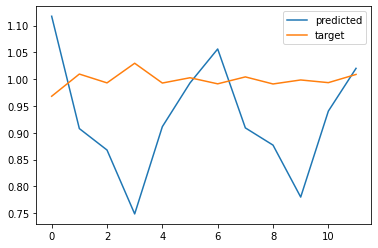

/tmp/ipykernel_2116/2645358702.py:157: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "past_cont": torch.tensor(self.past_cont[i], dtype=torch.float32),
/tmp/ipykernel_2116/2645358702.py:158: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "past_disc": torch.tensor(self.past_disc[i], dtype=torch.float32),
/tmp/ipykernel_2116/2645358702.py:159: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "target_seq": torch.tensor(self.target_seq[i], dtype=torch.float32),
/tmp/ipykernel_2116/2645358702.py:160: UserWarning: To copy construct from a tensor, i

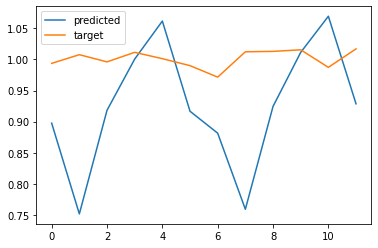

/tmp/ipykernel_2116/2645358702.py:157: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "past_cont": torch.tensor(self.past_cont[i], dtype=torch.float32),
/tmp/ipykernel_2116/2645358702.py:158: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "past_disc": torch.tensor(self.past_disc[i], dtype=torch.float32),
/tmp/ipykernel_2116/2645358702.py:159: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "target_seq": torch.tensor(self.target_seq[i], dtype=torch.float32),
/tmp/ipykernel_2116/2645358702.py:160: UserWarning: To copy construct from a tensor, i

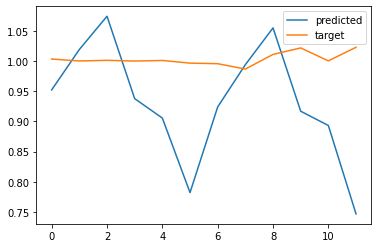

/tmp/ipykernel_2116/2645358702.py:157: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "past_cont": torch.tensor(self.past_cont[i], dtype=torch.float32),
/tmp/ipykernel_2116/2645358702.py:158: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "past_disc": torch.tensor(self.past_disc[i], dtype=torch.float32),
/tmp/ipykernel_2116/2645358702.py:159: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "target_seq": torch.tensor(self.target_seq[i], dtype=torch.float32),
/tmp/ipykernel_2116/2645358702.py:160: UserWarning: To copy construct from a tensor, i

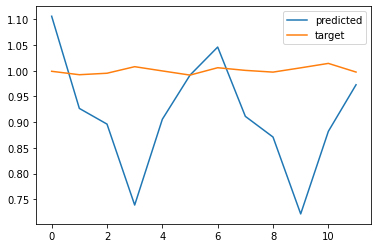

/tmp/ipykernel_2116/2645358702.py:157: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "past_cont": torch.tensor(self.past_cont[i], dtype=torch.float32),
/tmp/ipykernel_2116/2645358702.py:158: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "past_disc": torch.tensor(self.past_disc[i], dtype=torch.float32),
/tmp/ipykernel_2116/2645358702.py:159: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "target_seq": torch.tensor(self.target_seq[i], dtype=torch.float32),
/tmp/ipykernel_2116/2645358702.py:160: UserWarning: To copy construct from a tensor, i

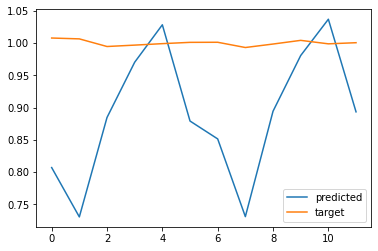

/tmp/ipykernel_2116/2645358702.py:157: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "past_cont": torch.tensor(self.past_cont[i], dtype=torch.float32),
/tmp/ipykernel_2116/2645358702.py:158: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "past_disc": torch.tensor(self.past_disc[i], dtype=torch.float32),
/tmp/ipykernel_2116/2645358702.py:159: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "target_seq": torch.tensor(self.target_seq[i], dtype=torch.float32),
/tmp/ipykernel_2116/2645358702.py:160: UserWarning: To copy construct from a tensor, i

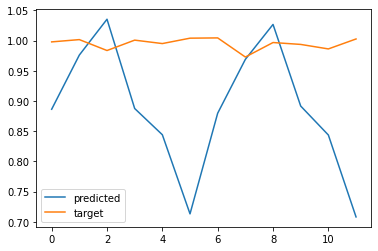

/tmp/ipykernel_2116/2645358702.py:157: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "past_cont": torch.tensor(self.past_cont[i], dtype=torch.float32),
/tmp/ipykernel_2116/2645358702.py:158: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "past_disc": torch.tensor(self.past_disc[i], dtype=torch.float32),
/tmp/ipykernel_2116/2645358702.py:159: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "target_seq": torch.tensor(self.target_seq[i], dtype=torch.float32),
/tmp/ipykernel_2116/2645358702.py:160: UserWarning: To copy construct from a tensor, i

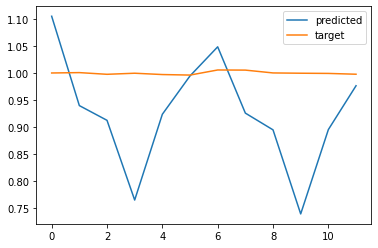

/tmp/ipykernel_2116/2645358702.py:157: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "past_cont": torch.tensor(self.past_cont[i], dtype=torch.float32),
/tmp/ipykernel_2116/2645358702.py:158: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "past_disc": torch.tensor(self.past_disc[i], dtype=torch.float32),
/tmp/ipykernel_2116/2645358702.py:159: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "target_seq": torch.tensor(self.target_seq[i], dtype=torch.float32),
/tmp/ipykernel_2116/2645358702.py:160: UserWarning: To copy construct from a tensor, i

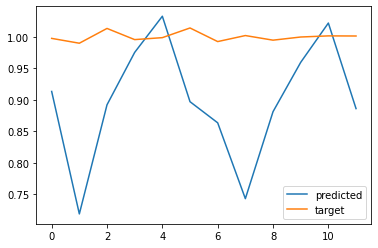

/tmp/ipykernel_2116/2645358702.py:157: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "past_cont": torch.tensor(self.past_cont[i], dtype=torch.float32),
/tmp/ipykernel_2116/2645358702.py:158: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "past_disc": torch.tensor(self.past_disc[i], dtype=torch.float32),
/tmp/ipykernel_2116/2645358702.py:159: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "target_seq": torch.tensor(self.target_seq[i], dtype=torch.float32),
/tmp/ipykernel_2116/2645358702.py:160: UserWarning: To copy construct from a tensor, i

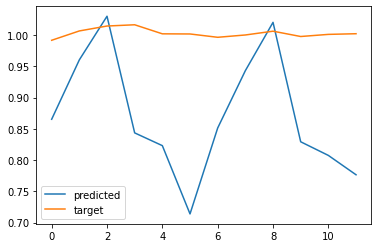

/tmp/ipykernel_2116/2645358702.py:157: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "past_cont": torch.tensor(self.past_cont[i], dtype=torch.float32),
/tmp/ipykernel_2116/2645358702.py:158: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "past_disc": torch.tensor(self.past_disc[i], dtype=torch.float32),
/tmp/ipykernel_2116/2645358702.py:159: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "target_seq": torch.tensor(self.target_seq[i], dtype=torch.float32),
/tmp/ipykernel_2116/2645358702.py:160: UserWarning: To copy construct from a tensor, i

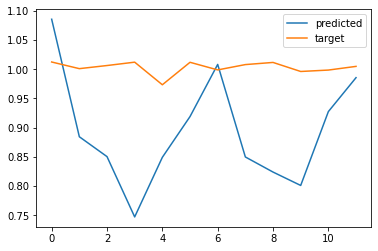

In [14]:
device = torch.device("cuda")
model.eval() 
for batch in test_dataloader: 
    past_cont = batch['past_cont'].to(device) 
    past_disc = batch['past_disc'].to(device) 
    target_seq = batch['target_seq'].to(device) 
    future_disc = batch['future_disc'].to(device)
        
    past_disc = one_hot(past_disc, [24, 32, 13]) 
    future_disc = one_hot(future_disc, [24, 32, 13]) 
        
    model.reset(batch_size=past_cont.shape[0], gpu=True) 
    with torch.no_grad():
        net_out, vs_weights = model(past_cont, past_disc, None, future_disc) 
    net_out = net_out.squeeze(dim=2) 
    
    predicted = net_out[32,:].detach().cpu().numpy() 
    actual = target_seq[32,:].detach().cpu().numpy() 
    
    #diff = actual[0] - predicted[0] 
    #predicted += diff 
    
    plt.plot(predicted, label="predicted") 
    plt.plot(actual, label="target") 
    plt.legend()
    plt.show() 
    

In [17]:
predicted, actual

(array([1.0855697 , 0.88436157, 0.8503458 , 0.74708307, 0.84912527,
        0.918911  , 1.0082173 , 0.84974307, 0.82390165, 0.8009642 ,
        0.92743677, 0.98555464], dtype=float32),
 array([1.0123568 , 1.0009677 , 1.0063108 , 1.0120685 , 0.9733709 ,
        1.0118514 , 0.99880064, 1.0079244 , 1.0116103 , 0.9961248 ,
        0.99854   , 1.0048519 ], dtype=float32))

In [23]:
price = 1000 

pred_prices = [price] 
start = 1000 
for i in range(len(predicted)): 
    pred_price = start * predicted[i]  
    pred_prices.append(pred_price) 
    start = pred_price 
    
actual_prices = [price] 
start = 1000 
for i in range(len(actual)): 
    actual_price = price * actual[i] 
    actual_prices.append(actual_price) 
    start = actual_price

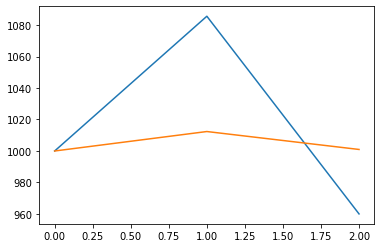

In [27]:
plt.plot(pred_prices[:3])
plt.plot(actual_prices[:3]) 